# Particle Tracking Velocimtry (PTV) using KNN 

In [4]:
# import modules for the detection of the particles 
import glob
import multiprocessing as mp
import numpy as np 
import pandas as pd
import shutil
import time 
import gc
import os
from sklearn.neighbors import NearestNeighbors as nnbrs

# import plotting libraries 
import matplotlib.pyplot as plt
Big_color = '#F46D7D'
Small_color = '#9779f4'
import random
plt.style.use('classic')

## Now, we check the KNN with our test code 

In [5]:
# function to perform the Particle tracking via using KNN
def vel_spins(frame1, frame2):
    '''
    This function uses KNN to match the particles with there image ain two consequetive frames
    Params:
        frame1: preceding snapshot
        frame2: succeeding snapsot
    '''
    
    # convert the positional data from the preceding snap into correct fromat of  [xi, yi] 
    counter_frame1 = [];
    for i in range(len(frame1.values)):
        counter_frame1.append(frame1.values[i][1:])
    frame1_train_data = np.array(counter_frame1) 
    
    # convert the positional data from the succeeding snap into correct fromat of  [xi, yi]
    counter_frame2 =[];
    for i in range(len(frame2.values)):
        counter_frame2.append(frame2.values[i][1:])
    frame2_train_data = np.array(counter_frame2)
    
    # ...... Implementation of the KNN to find the nearest neighbour
    
    # instatiate the KNN model setting K =1 and the algorithm of ball tree for more efficient search
    train_data = nnbrs(n_neighbors=1, algorithm='ball_tree')
    
    # train the model using the data from the preceding SnapShot
    train_data.fit(frame1_train_data)
    
    # Use this aforementioned trained model to predict the nearest neighbour of 
    # Here we implement the logic .... the nearest neighbour will be the image of itself!!!
    
    _,indices = train_data.kneighbors(frame2_train_data) 
    # indices above provide the tags (refernce) to connect the images of the same particles between two frames 
    
    # Use the above tags to re-arrange the particle positions from the preceding frame 
    add_X = []
    add_Y = []
    for x in indices:
        add_X.append(frame1.iloc[x]['X'])
        add_Y.append(frame1.iloc[x]['Y'])
    
    # attach the rearanged particle poisitons to the positions in the final frame 
    # to create a single master coordinate table by adding to frame 2
    frame2['XX'] = np.array(add_X)
    frame2['YY'] = np.array(add_Y)  
    
    frame2['dX'] = frame2['XX'] - frame2['X']
    frame2['dY'] = frame2['YY'] - frame2['Y']
    
    # compute  ''' Displacement''' for gnerating the velocity vectors
    frame2['dR'] = np.sqrt(frame2['dX']**2 + frame2['dY']**2)
    
    # return the master table (udated frame 2) 
    return frame2 

In [6]:
# read the data from the tsv files~~~~~~
# 1st frame 
F_data  = pd.read_csv(r'Data\Trajectory\2F.tsv', sep = '\t')
NF_data  = pd.read_csv(r'Data\Trajectory\2NF.tsv', sep = '\t')

# 2nd frame
F_data_2 = pd.read_csv(r'Data\Trajectory\1F.tsv', sep='\t')
NF_data_2 = pd.read_csv(r'Data\Trajectory\1NF.tsv', sep='\t')


# .... Data Preprocessing step ....
# remove the extras  from F and NF particles which are result of poor image detection
NF_data['R'] = np.sqrt((NF_data['X'] - 700)**2 + (NF_data['Y'] - 700)**2)
NF_Data_cropped = NF_data[NF_data['R']<630]
F_data['R'] = np.sqrt((F_data['X'] - 700)**2 + (F_data['Y'] - 700)**2)
F_Data_cropped = F_data[F_data['R']<650]

NF_data_2['R'] = np.sqrt((NF_data_2['X'] - 700)**2 + (NF_data_2['Y'] - 700)**2)
NF_Data_cropped_2 = NF_data_2[NF_data_2['R']<630]
F_data_2['R'] = np.sqrt((F_data_2['X'] - 700)**2 + (F_data_2['Y'] - 700)**2)
F_Data_cropped_2 = F_data_2[F_data_2['R']<650]

In [7]:
# Add the arrows 
# process the white particles
F_data.drop(columns ='R', inplace = True)

# tag and augement the postiosninto a master table 
arrowdata_F = vel_spins(F_data_2[[' ', 'X', 'Y']],F_data)
arrowdata_F.dropna()
arrowdata_F = arrowdata_F[arrowdata_F['dR']<40]
arrowdata_F = arrowdata_F[arrowdata_F['dR']>0]

# for the dark particles 
NF_data.drop(columns ='R', inplace = True)

# tag and augement the postiosninto a master table 
arrowdata_NF = vel_spins(NF_data_2[[' ', 'X', 'Y']],NF_data)
arrowdata_NF.dropna()
arrowdata_NF = arrowdata_NF[arrowdata_NF['dR']<8]
arrowdata_NF = arrowdata_NF[arrowdata_NF['dR']>1]
arrowdata_NF['R'] = np.sqrt((arrowdata_NF['X']-704)**2 + (arrowdata_NF['Y']-704)**2)
arrowdata_NF = arrowdata_NF[arrowdata_NF['R']<650]

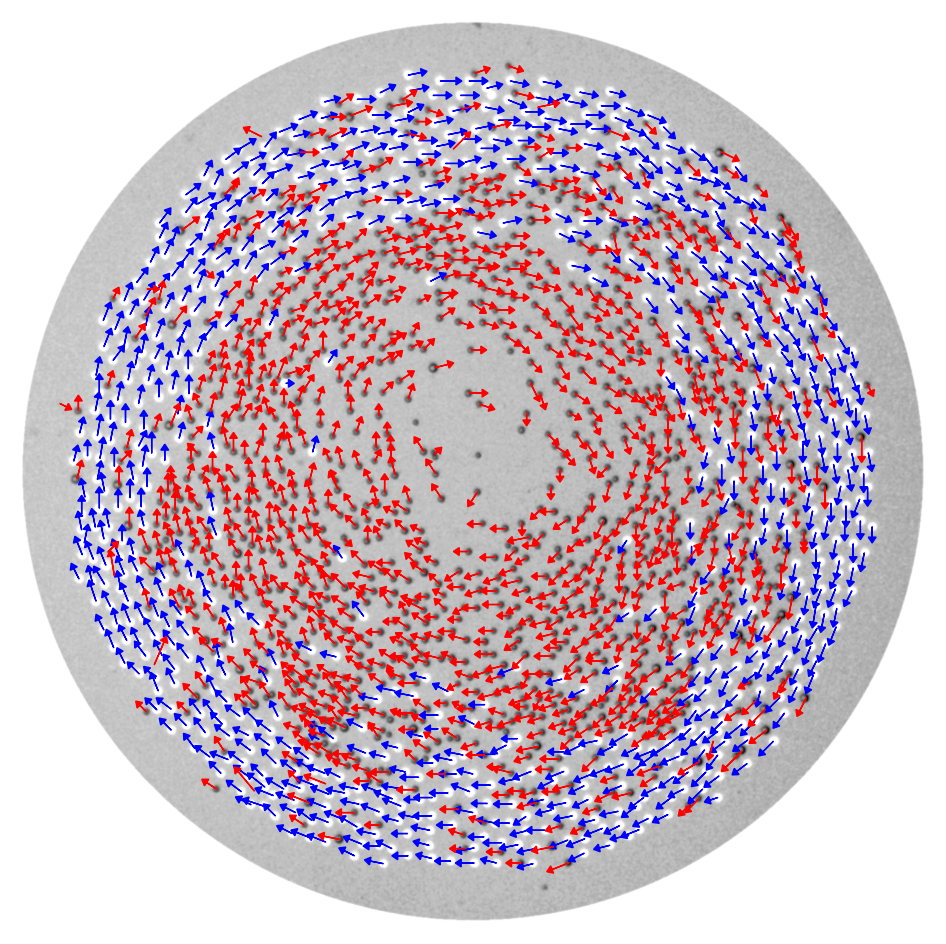

In [9]:
# # Plot the PTV ~~~~~~~~~~~~~
plt.style.use('default')
plt.figure(figsize = (12,12))
ax = plt.axes()
ax.axis('off')
#plt.scatter(F_Data_cropped['X'],F_Data_cropped['Y'],  s = 45, marker = 'o',c = Big_color)
#plt.scatter(NF_Data_cropped['X'],NF_Data_cropped['Y'],s = 45, marker = 'o', c=Small_color)
base_img = plt.imread('Base_image_1.tif')
plt.imshow(base_img, cmap = 'Greys_r')


# plot the arrows F
for i in range(0,len(arrowdata_F)):
    plt.arrow(arrowdata_F.iloc[i]['X'],arrowdata_F.iloc[i]['Y'],-arrowdata_F.iloc[i]['dX']*4,
              -arrowdata_F.iloc[i]['dY']*4, head_width=12, head_length=9, color = 'b')
# plot the arrows NF
for i in range(0,len(arrowdata_NF)):
    plt.arrow(arrowdata_NF.iloc[i]['X'],arrowdata_NF.iloc[i]['Y'],-arrowdata_NF.iloc[i]['dX']*5,
              -arrowdata_NF.iloc[i]['dY']*5, head_width=12, head_length=9, color = 'r', width= 0.3)
    
 